In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
BASE_DIR = '/content/driver/MyDrive/Colab Notebooks/Crypto-Forecasting/'
ETH_DIR = os.path.join(BASE_DIR, 'ETHUSDT_merged.csv')

### BTC

In [ ]:
df_ETH = pd.read_csv(ETH_DIR)
df_ETH.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,171.52,172.89,171.36,172.45,5981.16399,2019-09-01 00:59:59.999,1.030126e+06,3753,3576.32332,615886.585686
1,2019-09-01 01:00:00,172.47,173.42,172.41,172.71,7929.54701,2019-09-01 01:59:59.999,1.372183e+06,3310,5532.93656,957301.238661
2,2019-09-01 02:00:00,172.67,172.97,172.02,172.43,2650.04457,2019-09-01 02:59:59.999,4.568114e+05,2666,1333.25886,229852.921103
3,2019-09-01 03:00:00,172.41,172.83,172.32,172.57,2676.49085,2019-09-01 03:59:59.999,4.618308e+05,2612,1445.60395,249450.124375
4,2019-09-01 04:00:00,172.50,172.74,172.11,172.46,2596.85893,2019-09-01 04:59:59.999,4.476401e+05,2848,1524.31952,262782.612091


In [ ]:
# quick overview the dataset
df_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open_time               32821 non-null  object 
 1   open                    32821 non-null  float64
 2   high                    32821 non-null  float64
 3   low                     32821 non-null  float64
 4   close                   32821 non-null  float64
 5   volume                  32821 non-null  float64
 6   close_time              32821 non-null  object 
 7   quote_volume            32821 non-null  float64
 8   count                   32821 non-null  int64  
 9   taker_buy_volume        32821 non-null  float64
 10  taker_buy_quote_volume  32821 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
# set open time as an index
df_ETH = df_ETH.set_index('open_time')

In [ ]:
# convert the object into datetime format
df_ETH.index = pd.to_datetime(df_ETH.index, format="%Y-%m-%d")

### Plot

In [ ]:
def plot_series(data, string):
  fig, ax = plt.subplots(figsize=(20, 6))
  plt.plot(data[string])
  plt.xlabel('Date')
  plt.ylabel(string)

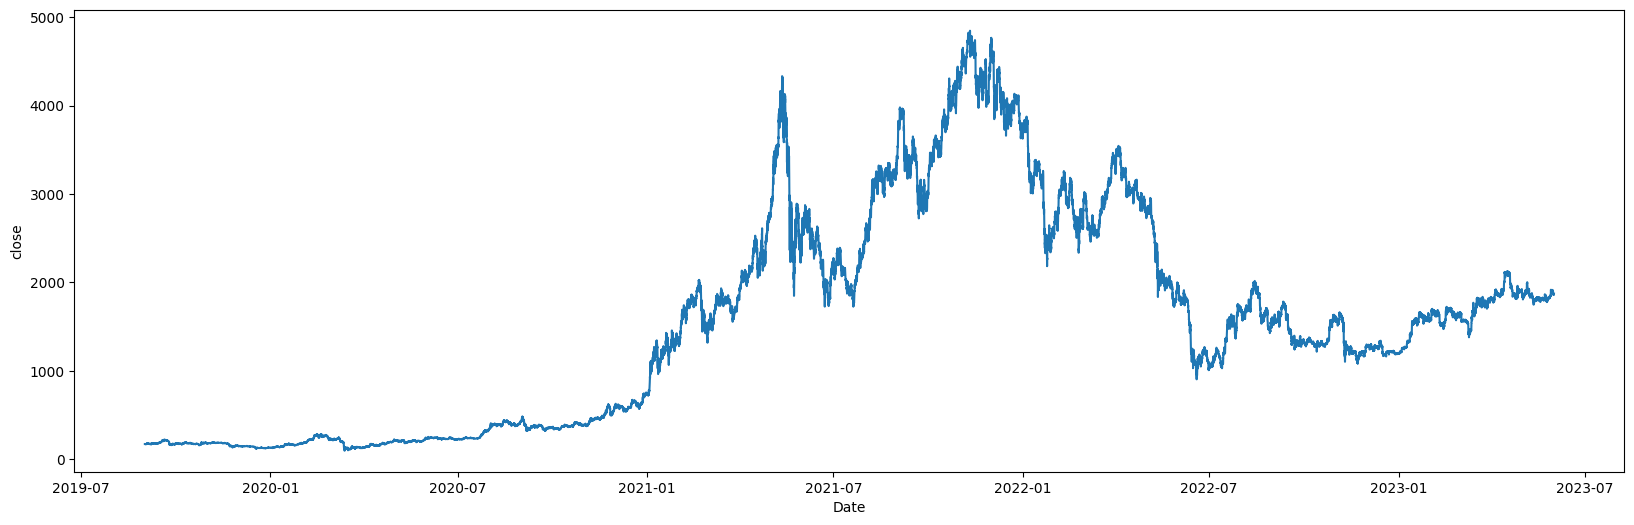

In [ ]:
# Plot close price of BTC
plot_series(df_ETH, 'close')

<Axes: >

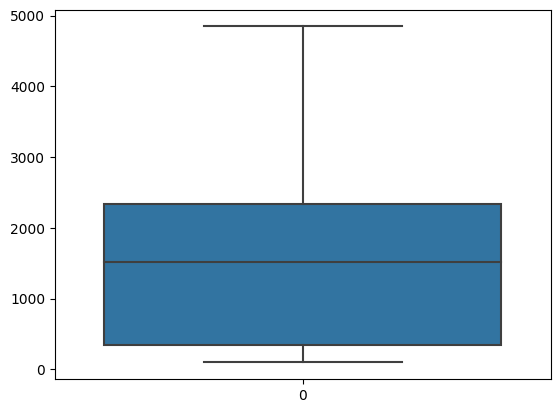

In [ ]:
sns.boxplot(df_ETH['close'])

### Split the Dataset

In [ ]:
cutoff_test = int(len(df_ETH)*.9)

eth_train = df_ETH['close'][:cutoff_test]
eth_test = df_ETH['close'][cutoff_test:]

### Naive Forecast

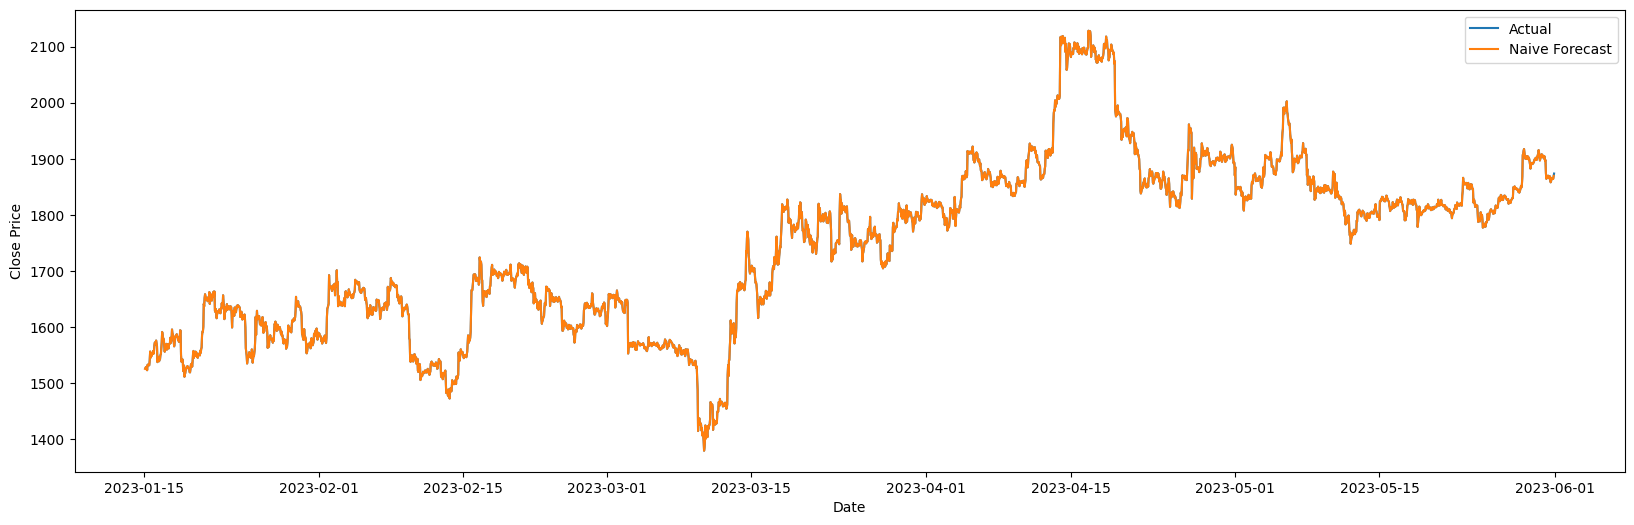

In [ ]:
naive_forecast = df_ETH['close'][cutoff_test-1:-1]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(eth_test, label="Actual")
plt.plot(naive_forecast, label="Naive Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

### Computing Metrics

In [ ]:
def computing_metrics(actual, predicted):
  """
    Agrs:
      actual: pd.Series
      predicted: pd.Series

    Returns:
      mse: float    -> mean squared error
      mae: float    -> mean absolute error
  """
  # caculate mean squared error
  mse = tf.keras.metrics.mean_squared_error(actual, predicted).numpy()
  # calculate mean absolute error
  mae = tf.keras.metrics.mean_absolute_error(actual, predicted).numpy()

  return mse, mae

In [ ]:
# calculate the mae and mse of naive forecast

mse, mae = computing_metrics(eth_test, naive_forecast)

print(f"Mean Squared Error: {round(mse, 3)}")
print(f"Mean Absolute Error: {round(mae, 3)}")

Mean Squared Error: 93.579
Mean Absolute Error: 5.985


In [ ]:
eth_train

open_time
2019-09-01 00:00:00     172.45
2019-09-01 01:00:00     172.71
2019-09-01 02:00:00     172.43
2019-09-01 03:00:00     172.57
2019-09-01 04:00:00     172.46
                        ...   
2023-01-14 23:00:00    1549.90
2023-01-15 00:00:00    1527.99
2023-01-15 01:00:00    1528.40
2023-01-15 02:00:00    1522.23
2023-01-15 03:00:00    1525.40
Name: close, Length: 29538, dtype: float64

### Normalization

In [ ]:
scaler = MinMaxScaler()
close_price = eth_train.values.reshape(-1, 1)
# df_BTC['close']= scaler.fit_transform(close_price)
eth_train_scaled = scaler.fit_transform(close_price)

In [ ]:
SCALER_DIR = os.path.join(BASE_DIR, 'Scaler_ETH.pkl')
with open(SCALER_DIR, 'wb') as f:
  pickle.dump(scaler, f)

### Prepare features and labels

In [ ]:
def windowed(data, window_size, batch_size, shuffle_buffer):
  """
    Args:
      data: array of float
      window_size: int
      batch_size: int
      shuffle_buffer: int

    Returns:
      data: tf.Dataset
  """

  # Generate a TF Dataset
  data = tf.data.Dataset.from_tensor_slices(data)

  # window the data
  data = data.window(window_size+1, shift=1, drop_remainder=True)

  # Flatten the windows
  data = data.flat_map(lambda window: window.batch(window_size + 1))

  # create a tuples with features and labels
  data = data.map(lambda window: (window[:-1], window[-1]))

  # shuffle the windows
  data = data.shuffle(shuffle_buffer)

  # create batchs
  data = data.batch(batch_size).prefetch(1)

  return data

### Parameters

In [ ]:
window_size = 10
batch_size = 256
shuffle_buffer = 1000

### Generate dataset windows

In [ ]:
data_eth = windowed(eth_train_scaled, window_size, batch_size, shuffle_buffer)

In [ ]:
for window in data_eth.take(1):
  print(f'data type: {type(window)}')
  print(f'number of elements in the tuple: {len(window)}')
  print(f'shape of feature of first element: {window[0].shape}')
  print(f'shape of labels of first element: {window[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of feature of first element: (256, 10, 1)
shape of labels of first element: (256, 1)


### Build the Model

In [ ]:
def build_model(window_size):
  """
    Args:
      window_size: int

    Returns:
      model:
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
  ])

  # model = tf.keras.models.Sequential([
  #         tf.keras.layers.Conv1D(filters=64, kernel_size=3,
  #                             strides=1,
  #                             activation="relu",
  #                             padding='causal',
  #                             input_shape=[window_size, 1]),
  #         tf.keras.layers.LSTM(64, return_sequences=True),
  #         tf.keras.layers.LSTM(64),
  #         tf.keras.layers.Dense(30, activation="relu"),
  #         tf.keras.layers.Dense(10, activation="relu"),
  #         tf.keras.layers.Dense(1),
  #         tf.keras.layers.Lambda(lambda x: x * 400)
  # ])



  return model

### Tune the Learning Rate

In [ ]:
def tune_learning_rate(model, data):
  """
    Args:
      model:
      data:

    Returns:
      history
  """

  # set learning rate scheduler
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10 ** (epoch/10))

  # Initialize the optimizer
  optimizer = tf.keras.optimizers.Adam()

  # compile the model
  model.compile(
      loss="mse",
      # loss=tf.keras.losses.Huber(),
      optimizer=optimizer
  )

  history = model.fit(data, epochs=100, callbacks=[lr_schedule])

  return history

In [ ]:
epoch = 100
1e-8 * 8 ** (epoch/10)

10.73741824

In [ ]:
# build the model
model_tune = build_model(window_size)
lr_history = tune_learning_rate(model_tune, data_eth)

Epoch 1/100
116/116 [==============================] - 55s 391ms/step - loss: 7.7141 - lr: 1.0000e-08
Epoch 2/100
116/116 [==============================] - 45s 383ms/step - loss: 7.6620 - lr: 1.2589e-08
Epoch 3/100
116/116 [==============================] - 43s 371ms/step - loss: 7.6524 - lr: 1.5849e-08
Epoch 4/100
116/116 [==============================] - 43s 366ms/step - loss: 7.5381 - lr: 1.9953e-08
Epoch 5/100
116/116 [==============================] - 42s 365ms/step - loss: 7.4409 - lr: 2.5119e-08
Epoch 6/100
116/116 [==============================] - 43s 369ms/step - loss: 7.2943 - lr: 3.1623e-08
Epoch 7/100
116/116 [==============================] - 46s 392ms/step - loss: 7.1627 - lr: 3.9811e-08
Epoch 8/100
116/116 [==============================] - 44s 377ms/step - loss: 6.9888 - lr: 5.0119e-08
Epoch 9/100
116/116 [==============================] - 42s 360ms/step - loss: 6.7555 - lr: 6.3096e-08
Epoch 10/100
116/116 [==============================] - 44s 376ms/step - loss: 6.4

### Plot Learning Rate

In [ ]:
def plot_learning_rate(history, zoom_split):
  # learning rate array
  lr = 1e-8 * (10**(np.arange(100)/20))
  plt.figure(figsize=(10,6))
  plt.semilogx(history.history['lr'][:zoom_split], history.history['loss'][:zoom_split])
  plt.tick_params('both', length=10, width=1, which='both')
  # plt.axis([1e-8, 100])

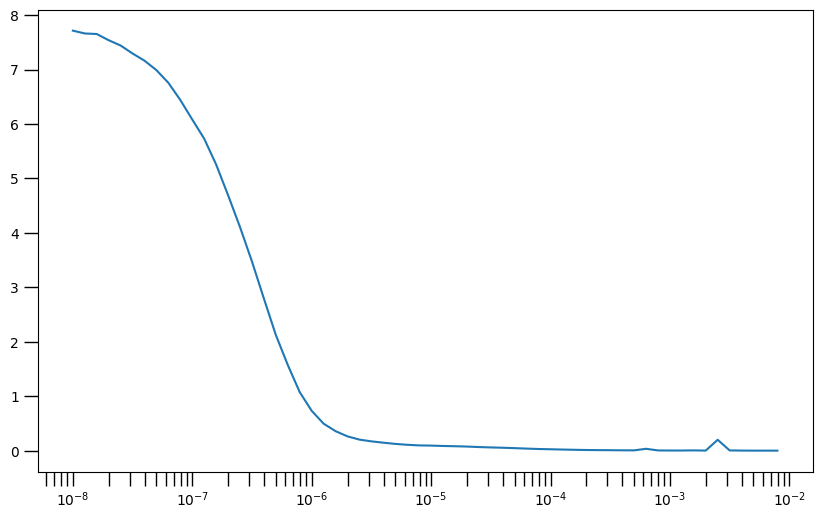

In [ ]:
plot_learning_rate(lr_history, zoom_split=60)

In [ ]:
def compile_model(model, data):
  # set the learning rate
  learning_rate = 1e-4

  # set the optimizer
  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # set the training parameters
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']
                )

  # train the model
  history = model.fit(data, epochs=50)

  return history

In [ ]:
# reset the states
tf.keras.backend.clear_session()

# build the model
model = build_model(window_size)

# train the model
history = compile_model(model, data_eth)

Epoch 1/50
116/116 [==============================] - 50s 355ms/step - loss: 0.0220 - mae: 0.0984
Epoch 2/50
116/116 [==============================] - 41s 354ms/step - loss: 0.0091 - mae: 0.0582
Epoch 3/50
116/116 [==============================] - 41s 355ms/step - loss: 0.0066 - mae: 0.0503
Epoch 4/50
116/116 [==============================] - 42s 356ms/step - loss: 0.0047 - mae: 0.0421
Epoch 5/50
116/116 [==============================] - 41s 352ms/step - loss: 0.0039 - mae: 0.0404
Epoch 6/50
116/116 [==============================] - 41s 352ms/step - loss: 0.0031 - mae: 0.0343
Epoch 7/50
116/116 [==============================] - 41s 353ms/step - loss: 0.0026 - mae: 0.0309
Epoch 8/50
116/116 [==============================] - 41s 357ms/step - loss: 0.0022 - mae: 0.0281
Epoch 9/50
116/116 [==============================] - 43s 373ms/step - loss: 0.0019 - mae: 0.0262
Epoch 10/50
116/116 [==============================] - 42s 357ms/step - loss: 0.0017 - mae: 0.0244
Epoch 11/50
116/116

Text(0, 0.5, 'Loss')

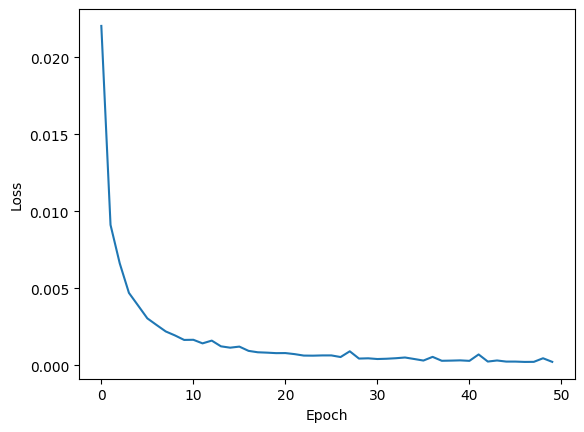

In [ ]:
# get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# get epochs number
epochs = range(len(loss))

# plot
# plt.plot(history.history['mae'])
plt.plot(history.history['loss'][:])
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Save Model

In [ ]:
MODEL_DIR = os.path.join(BASE_DIR, 'ETH_saved_model.h5')
model.save(MODEL_DIR)

### Model Prediction

In [ ]:
# Normalize test set
close_price = eth_test.values.reshape(-1, 1)
eth_test_scaled = scaler.transform(close_price)

In [ ]:
forecast = []

# reduce the original series
forecast_series = df_ETH['close'][cutoff_test-window_size:]

# Normalize the forecast series
close_price = forecast_series.values.reshape(-1, 1)
forecast_scaled = scaler.transform(close_price)

In [ ]:
# use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  prediction = model.predict(forecast_scaled[time:time + window_size][np.newaxis])
  forecast.append(prediction)

# convert to a numpy array and drop single dimensional axis
result = np.array(forecast).squeeze()

1/1 [==============================] - 0s 28ms/step


In [ ]:
# inverse the normalization
eth_forecast = scaler.inverse_transform(result.reshape(-1,1))
eth_forecast = np.array(eth_forecast).squeeze()